## Import Packages

In [1]:
from tkinter import Tk
from tkinter.filedialog import askopenfilenames
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.lines as mlines
import os
from scipy import integrate
from scipy.interpolate import splprep, splev

## Define Useful Functions

In [2]:
def importCells(listLabels, listFilePath, include_start_rest=False):
    """Imports CSV file from each directory (string) in listFilePath and puts corresponding listLabels string as key"""
    if len(listFilePath) == len(listLabels):
        mydic = {}
        for i in range(len(listLabels)):
            dbtable = pd.read_csv(listFilePath[i], sep='\t', skiprows=1)
            dbtable.drop(labels=[re.search('Unnamed.*', i)[0] for i in dbtable.columns if re.search('Unnamed.*', i)], axis=1, inplace=True)
            current_name = [re.search('I \[.*', i)[0] for i in dbtable.columns if re.search('I \[.*', i)][0]
            dbtable.loc[dbtable.loc[(dbtable["Z1 []"] == 1) & (dbtable["I [mA]"].isna())].index, "Z1 []"] = 0
            if not include_start_rest:
                dbtable.drop(dbtable.loc[(dbtable["Z1 []"] == 0) & (dbtable["I [mA]"].isna())].index, axis='index', inplace=True)
            dbtable['State'] = dbtable.apply(lambda x: astrol_state_classifier(x, current_name), axis=1)
            mydic[listLabels[i]] = dbtable
        return mydic
    else:
        print("Error")

def dic_to_db(mydic):
    """Converts the dictionary from importCells to a pandas Dataframe"""
    new_table = pd.DataFrame()
    for key in mydic:
        cell_data = mydic[key]
        cycles = cell_data.groupby('Z1 []')['C [Ah/kg]'].min().index.values.tolist()
        charge_cap = cell_data.groupby('Z1 []')['C [Ah/kg]'].max().values
        discharge_cap = cell_data.groupby('Z1 []')['C [Ah/kg]'].min().values*-1
        coulombic_eff = discharge_cap/charge_cap
        cell_table = pd.DataFrame(data={'Cell': [key]*len(cycles), 'Cycle': cycles, 'Charge Capacity [mAh/g]': charge_cap, 'Discharge Capacity [mAh/g]': discharge_cap, 'Coulombic Efficiency': coulombic_eff})
        new_table = pd.concat([new_table, cell_table], axis=0)
    return new_table

def astrol_state_classifier(row, current_name):
    """Classifier for pandas dataframe apply function"""
    try: 
        if re.search('.*New program step', row['Comment']):
            if row[current_name] > 0:
                return 'Discharge'
            else:
                return 'Charge'
        else:
            if row[current_name] > 0:
                return 'Charge'
            else:
                return 'Discharge'
    except TypeError:
        if row[current_name] >= 0:
            return 'Charge'
        else:
            return 'Discharge'

def q_func(df, TT_min):
    """Calculates capacity manually"""
    Q = (df['TT [min]']-TT_min)*df['I [mA]']
    return Q

def nominal_voltages(all_df, all_features):
    """Determines the average of the dis/charge curves (also known as nominal voltages)"""
    for file in all_df.groupby("Cell").groups.keys():
        for cycle in range(1, all_df.query("Cell == @file")['Z1 []'].max()+1):
            for state in ['Charge', 'Discharge']:
                working_db = all_df.query("Cell == @file & `Z1 []` == @cycle & State == @state")
                if state == 'Discharge':
                    working_db['C [Ah/kg]'] *= -1
                integral = integrate.trapezoid(working_db['U [V]'][1:], x = working_db['C [Ah/kg]'][1:])
                nom_volt = integral/(working_db['C [Ah/kg]'][1:].max() - working_db['C [Ah/kg]'][1:].min())
                all_features.loc[(all_features['Cell'] == file) & (all_features['Cycle'] == cycle), "Nominal "+state+" Voltage"] = nom_volt
                all_features.loc[(all_features['Cell'] == file) & (all_features['Cycle'] == cycle), state+"Energy"] = integral

def dqdv_calc(q,v,V_resampling=0.004):
    """Calculates dqdv for plot"""
    #preprocess data
    okay = np.where(np.abs(np.diff(v)) + np.abs(np.diff(q)) > 0)
    xp = np.r_[v[okay], v[-1]]
    yp = np.r_[q[okay], q[-1]]

    #calculate spline interpolation
    tck, u = splprep([xp, yp], s=0.00001)
    u_vals = np.linspace(0, 1, 5000)
    y_vals = splev(u_vals, tck)
    
    #Visualize fit
    #plt.plot(xp, yp, 'k-')
    #plt.plot(y_vals[0], y_vals[1], 'r-')
    #plt.show()
    
    #resample data
    start_indx = 0
    resampling_indx = [start_indx]
    while start_indx < len(u_vals)-1:
        generator_exp = (i for i in range(start_indx+1, len(u_vals)) if np.abs(y_vals[0][i]-y_vals[0][start_indx]) >= V_resampling)
        idx = next(generator_exp, len(u_vals)-1)
        resampling_indx.append(idx)
        start_indx = idx
    dqdv_u_vals = u_vals[resampling_indx]

    #calculate dqdv
    v_vals = splev(dqdv_u_vals, tck)
    dqdvdu = splev(dqdv_u_vals, tck, der=1)
    dqdv = dqdvdu[1]/dqdvdu[0]
    return np.array([v_vals[0], dqdv])

## Import Data Files

In [3]:
# Create Dataframe and dictionary for all imported data files
all_features = pd.DataFrame()
all_df = pd.DataFrame()
all_dic = {}

In [4]:
# Add files to be imported into Dataframe (can be run more than once to append new files to already imported data)
Tk().withdraw()
filenames = askopenfilenames()
if isinstance(filenames, tuple):
    # load selected files
    local_dic = importCells([i.split('/')[-1] for i in filenames], [i for i in filenames], include_start_rest=False)
    # if there are already files imported check to see if there are duplicates
    if len(all_df):
        duplicates = set(all_df.index.levels[0].values.tolist()).intersection(local_dic.keys())
    else:
        duplicates = 0
    # if there are duplicates, ask to replace already imported file or skip (all duplicates, cannot choose which ones)
    if duplicates:
        reply = input("Following files have already been imported; replace? [y]/n"+"\n ".join('{}'.format(d) for d in duplicates))
        if re.search('.*n.*', reply.lower()):
            # do not import (skip)
            [local_dic.pop(i) for i in duplicates]
        else:
            # import (replace)
            for duplicate in duplicates:
                all_dic.pop(duplicate)
                all_df.drop(duplicate, level='Cell', inplace=True)
                all_df.index = all_df.index.remove_unused_levels()
    # avoid error about concatenating nothing
    if len(local_dic):
        all_dic = all_dic|local_dic
        all_features = pd.concat([all_features, dic_to_db(local_dic)], axis=0, ignore_index=True)
        all_df = pd.concat([all_df, pd.concat([local_dic[i] for i in local_dic.keys()], keys=local_dic.keys(), names=['Cell', 'OrigIndex'])])
elif isinstance(filenames, str):
    print('Import canceled; previously imported data files remain.')

nominal_voltages(all_df, all_features)

C:\Users\jacyi189\AppData\Local\Temp\ipykernel_20188\3942909760.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_db['C [Ah/kg]'] *= -1
C:\Users\jacyi189\AppData\Local\Temp\ipykernel_20188\3942909760.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_db['C [Ah/kg]'] *= -1


After importing (same process as for_reproducibility.ipynb), a further grouping is done based on water content (specified in the filename)

In [5]:
def waterSeries(row):
    try:
        if re.match('.*_16.txt', row['Cell']):
            return '16%'
        elif re.match('.*_08.txt', row['Cell']):
            return '8%'
        elif re.match('.*_04.txt', row['Cell']):
            return '4%'
        elif re.match('.*_02.txt', row['Cell']):
            return '2%'
        else:
            return '0%'
    except KeyError:
        if re.match('.*_16.txt', row.name[0]):
            return '16%'
        elif re.match('.*_08.txt', row.name[0]):
            return '8%'
        elif re.match('.*_04.txt', row.name[0]):
            return '4%'
        elif re.match('.*_02.txt', row.name[0]):
            return '2%'
        else:
            return '0%'
all_features['WaterContent'] = all_features.apply(lambda x: waterSeries(x), axis=1)
all_df['WaterContent'] = all_df.apply(lambda x: waterSeries(x), axis=1)
all_features['AvgHysteresis'] = all_features['Nominal Charge Voltage'] - all_features['Nominal Discharge Voltage']
all_features['EnergyEfficiency'] = all_features['DischargeEnergy']/all_features['ChargeEnergy']
all_features_pivot = all_features.melt(id_vars=['Cell', "Cycle", "WaterContent"], value_vars=['Charge Capacity [mAh/g]', 'Discharge Capacity [mAh/g]', 'ChargeEnergy', 'DischargeEnergy'])

In [25]:
# Run to remove file
#remove_file = '2022-10-21_20706_iJdK8FTkqk3jTNGjPfNoAJ_16.txt'
remove_file = '2022-10-21_82139_C4Kdj3GY9t8CzcFVH95xtg_16.txt'

all_dic.pop(remove_file)
all_df.drop(remove_file, level='Cell', inplace=True)
all_df.index = all_df.index.remove_unused_levels()
all_features = all_features[all_features['Cell'] != remove_file]


## Calculations
Calculate some means and standard deviations of the cycles

In [19]:

all_features.query('Cycle == 10').groupby('WaterContent').mean()


Cycle  Charge Capacity [mAh/g]  Discharge Capacity [mAh/g]  \
WaterContent                                                               
16%            10.0               123.808182                  120.553545   
2%             10.0               136.721818                  135.265455   
4%             10.0               136.067500                  135.290833   
8%             10.0               134.267273                  132.970000   

              Coulombic Efficiency  Nominal Charge Voltage  ChargeEnergy  \
WaterContent                                                               
16%                       0.969252                1.982710    244.903769   
2%                        0.989374                1.979640    270.060028   
4%                        0.994315                1.983524    269.288099   
8%                        0.990435                1.979714    265.200211   

              Nominal Discharge Voltage  DischargeEnergy  AvgHysteresis  \
WaterContent                                                              
16%                            1.752451       210.794377       0.230259   
2%                             1.763733       238.043209       0.215907   
4%                             1.760664       237.677012       0.222861   
8%                             1.758133       233.259033       0.221581   

              EnergyEfficiency  
WaterContent                    
16%                   0.856646  
2%                    0.881481  
4%                    0.882630  
8%                    0.879593

In [28]:
all_features.query('Cycle == 10').groupby('WaterContent').sem()

Cycle  Charge Capacity [mAh/g]  Discharge Capacity [mAh/g]  \
WaterContent                                                               
16%             0.0                 0.852914                    1.016792   
2%              0.0                 0.600772                    0.578239   
4%              0.0                 0.685668                    0.628480   
8%              0.0                 0.920988                    0.746685   

              Coulombic Efficiency  Nominal Charge Voltage  ChargeEnergy  \
WaterContent                                                               
16%                       0.002498                0.001910      1.658990   
2%                        0.002015                0.001508      1.231918   
4%                        0.000605                0.001318      1.338735   
8%                        0.002000                0.001472      1.700854   

              Nominal Discharge Voltage  DischargeEnergy  AvgHysteresis  \
WaterContent                                                              
16%                            0.001430         1.834081       0.003319   
2%                             0.001176         1.002335       0.002671   
4%                             0.001030         1.142000       0.002345   
8%                             0.001148         1.394543       0.002601   

              EnergyEfficiency  
WaterContent                    
16%                   0.002197  
2%                    0.001918  
4%                    0.001240  
8%                    0.001485

In [27]:
all_features.query('Cycle == 10').groupby('WaterContent').std()/all_features.query('Cycle == 10').groupby('WaterContent').mean()

Cycle  Charge Capacity [mAh/g]  Discharge Capacity [mAh/g]  \
WaterContent                                                               
16%             0.0                 0.019586                    0.023650   
2%              0.0                 0.014574                    0.014178   
4%              0.0                 0.017456                    0.016092   
8%              0.0                 0.022750                    0.018624   

              Coulombic Efficiency  Nominal Charge Voltage  ChargeEnergy  \
WaterContent                                                               
16%                       0.007590                0.002888      0.019247   
2%                        0.006753                0.002526      0.015129   
4%                        0.002108                0.002302      0.017221   
8%                        0.006699                0.002467      0.021271   

              Nominal Discharge Voltage  DischargeEnergy  AvgHysteresis  \
WaterContent                                                              
16%                            0.002445         0.024381       0.043241   
2%                             0.002211         0.013965       0.041025   
4%                             0.002026         0.016644       0.036452   
8%                             0.002166         0.019828       0.038930   

              EnergyEfficiency  
WaterContent                    
16%                   0.007552  
2%                    0.007218  
4%                    0.004866  
8%                    0.005598

## Plot

In [13]:
# Set global plotting settings
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2.8)
Startat0 = True
SoC = False

## Individual Plots
These individual plots were to test and determine which plots to include in the manuscript and what visual style to use. Skip to next section for the polished figure, which incorporates some of these plots.

### Dis/Charge Curve (Voltage vs capacity)

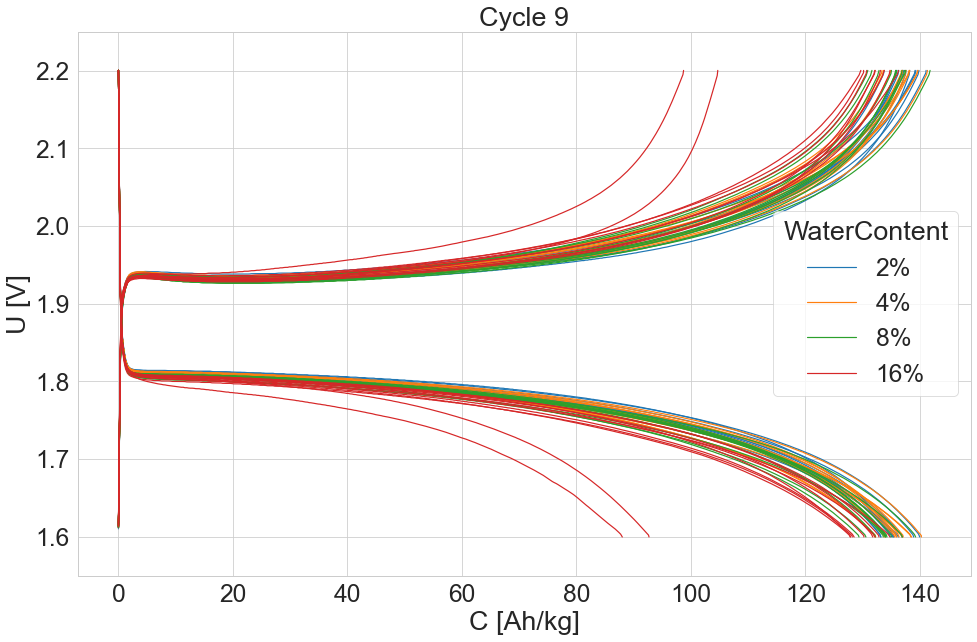

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(16, 10))
cycle = 9
charge_curve = all_df.query("`Z1 []` == @cycle & State == 'Charge'").reset_index(0)
discharge_curve = all_df.query("`Z1 []` == @cycle & State == 'Discharge'").reset_index(0)
if SoC:
    for file, val in charge_curve.groupby('Cell')['C [Ah/kg]'].max().to_dict().items():
        charge_curve.loc[charge_curve['Cell'] == file, 'C [Ah/kg]'] *= 100/val
        discharge_curve.loc[discharge_curve['Cell'] == file, 'C [Ah/kg]'] *= 100/val
if Startat0:
    discharge_curve = discharge_curve.assign(**{'C [Ah/kg]': discharge_curve['C [Ah/kg]']*-1})
else:
    for file, val in charge_curve.groupby('Cell')['C [Ah/kg]'].max().to_dict().items():
        discharge_curve.loc[discharge_curve['Cell'] == file, 'C [Ah/kg]'] += val 
sns.lineplot(y='U [V]', x='C [Ah/kg]', data=pd.concat([charge_curve, discharge_curve]).reset_index(), hue='WaterContent', style='State', dashes=False, units='Cell', estimator=None, ax=axes)
h, l = axes.get_legend_handles_labels()
axes.set_title('Cycle '+str(cycle))
axes.set_ylim(1.55, 2.25)
plt.legend(h[1:5], l[1:5], title=l[0], borderaxespad=0.5)
plt.show()

### Efficiency vs Cycle Plots

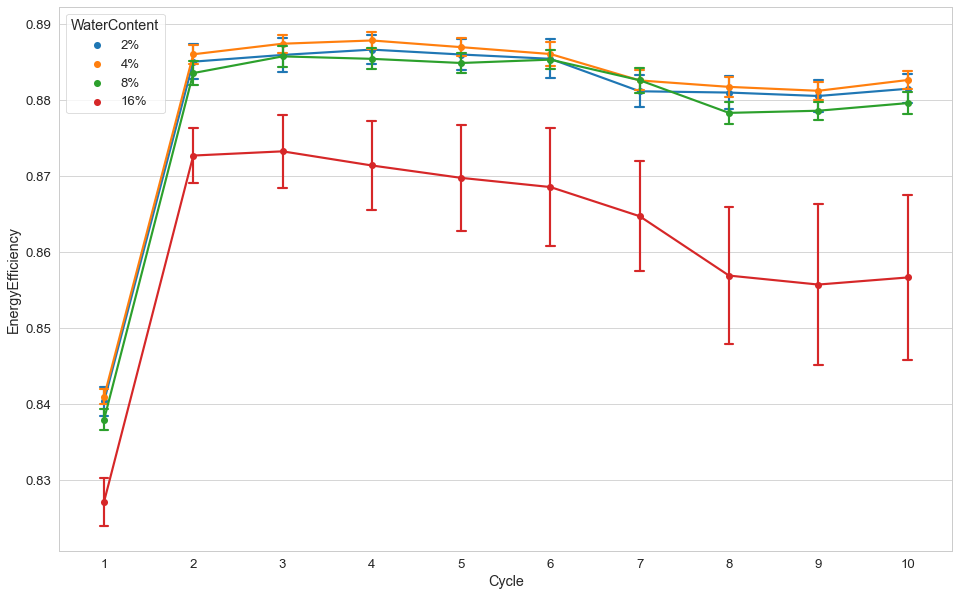

In [224]:
fig, axes = plt.subplots(1, 1, figsize=(16, 10))
sns.pointplot(x='Cycle', y='EnergyEfficiency', data=all_features.query('0 < Cycle < 11'), ax=axes, hue='WaterContent', capsize=0.1, errorbar='se')
plt.show()

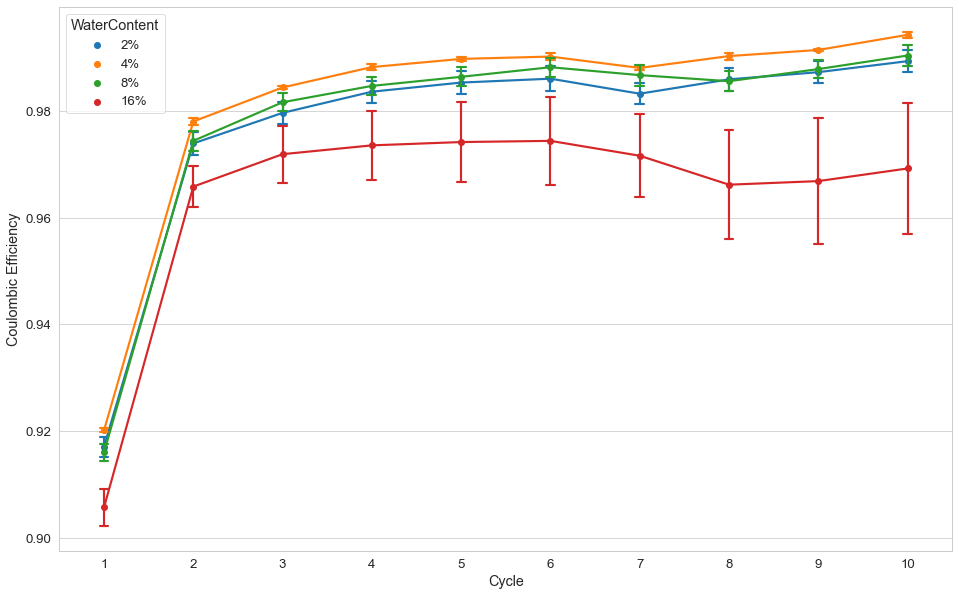

In [225]:
fig, axes = plt.subplots(1, 1, figsize=(16, 10))
#sns.swarmplot(x='Cycle', y='value', data=all_features_pivot.query('0 < Cycle < 11'), ax=axes, size=5, hue='variable', alpha=0.6)
sns.pointplot(x='Cycle', y='Coulombic Efficiency', data=all_features.query('0 < Cycle < 11'), ax=axes, hue='WaterContent', capsize=0.1, errorbar='se')
#sns.relplot(x='Cycle', y='value', data=all_features_pivot.query('0 < Cycle < 11'), hue='WaterContent', col='variable', markers=True, kind='line',  err_style="bars")
#axes.set_ylim(120,170)
#axes.set_ylabel('Capacity [mAh/g]')
#axes.legend(title='')
plt.show()

### Dis/Charge & Energy vs Cycle

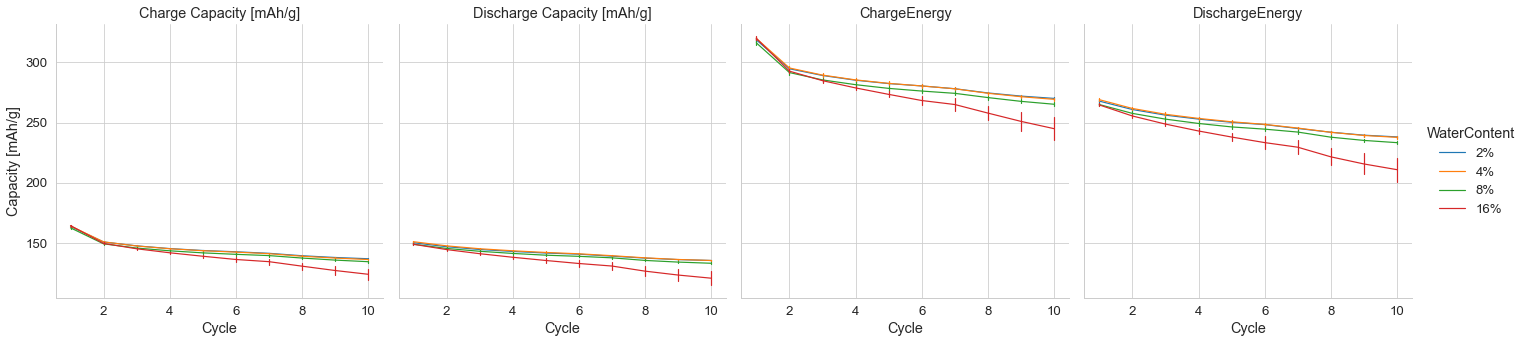

In [226]:
axes = sns.relplot(x='Cycle', y='value', data=all_features_pivot.query('0 < Cycle < 11'), hue='WaterContent', col='variable', markers=True, kind='line',  err_style="bars", errorbar='se')
#axes.set_ylim(120,170)
axes.set_titles(col_template="{col_name}")
axes.set_ylabels('Capacity [mAh/g]')
#axes.legend(title='')
plt.show()

### Nominal Charge and Discharge vs. Cycle

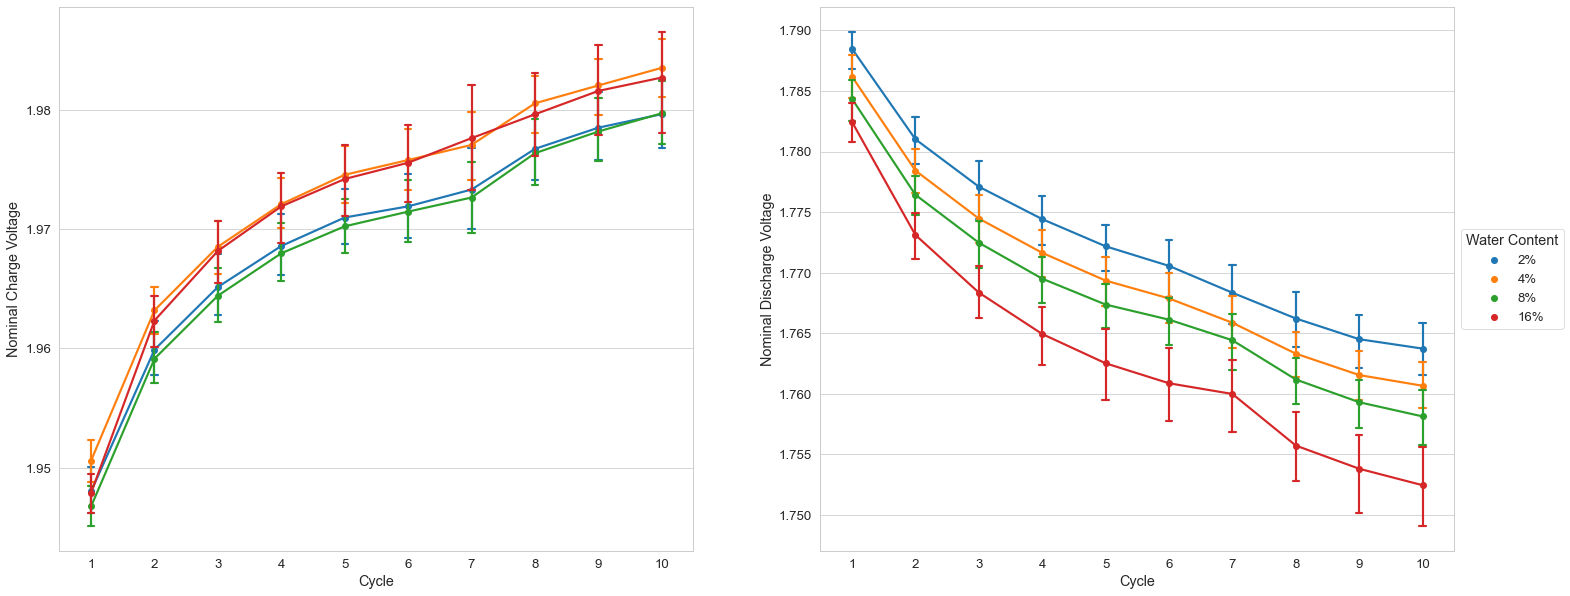

In [227]:
from turtle import title


fig, axes = plt.subplots(1, 2, figsize=(25, 10))
sns.pointplot(x='Cycle', y='Nominal Charge Voltage', data=all_features.query('0 < Cycle < 11'), ax=axes[0], hue='WaterContent', capsize=0.1)
sns.pointplot(x='Cycle', y='Nominal Discharge Voltage', data=all_features.query('0 < Cycle < 11'), ax=axes[1], hue='WaterContent', capsize=0.1)
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Water Content')
axes[0].get_legend().remove()
plt.show()

### Hysteresis vs. cycle

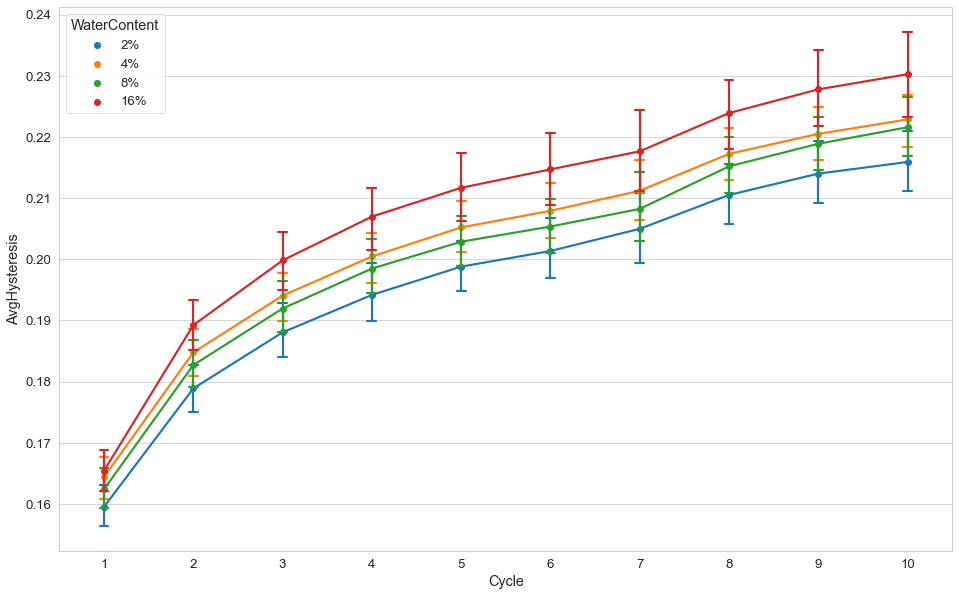

In [228]:
fig, axes = plt.subplots(1, 1, figsize=(16, 10))
#sns.swarmplot(x='Cycle', y='value', data=all_features_pivot.query('0 < Cycle < 11'), ax=axes, size=5, hue='variable', alpha=0.6)
sns.pointplot(x='Cycle', y='AvgHysteresis', data=all_features.query('0 < Cycle < 11'), ax=axes, hue='WaterContent', capsize=0.1)
#sns.relplot(x='Cycle', y='value', data=all_features_pivot.query('0 < Cycle < 11'), hue='WaterContent', col='variable', markers=True, kind='line',  err_style="bars")
#axes.set_ylim(120,170)
#axes.set_ylabel('Capacity [mAh/g]')
#axes.legend(title='')
plt.show()

### Calculating and plotting DqDV plots

In [10]:
# DqDv calculation
dqdv_df = pd.DataFrame()
for cell_n in all_df.index.levels[0].values:
    for s in ['Charge', 'Discharge']:
        for cycle in range(1,all_df['Z1 []'].max()+1):
            #print("Starting Dq/Dv calcultion for File: {}, Cycle: {}, {}".format(cell_n, cycle, s))
            working_section = all_df.query("Cell == @cell_n & State == @s & `Z1 []` == @cycle")
            xp = working_section['U [V]'].values
            yp = working_section['C [Ah/kg]'].values
            vals = dqdv_calc(yp,xp, 0.01)

            temp_dqdv_df = pd.DataFrame({'Cell': cell_n, 'Cycle': cycle, 'State': s, 'U [V]': vals[0], 'DqDv': vals[1], 'WaterContent': working_section.iloc[0]['WaterContent']})
            if s == 'Discharge':
                temp_dqdv_df['DqDv'] *= -1

            dqdv_df = pd.concat([dqdv_df, temp_dqdv_df], axis=0)

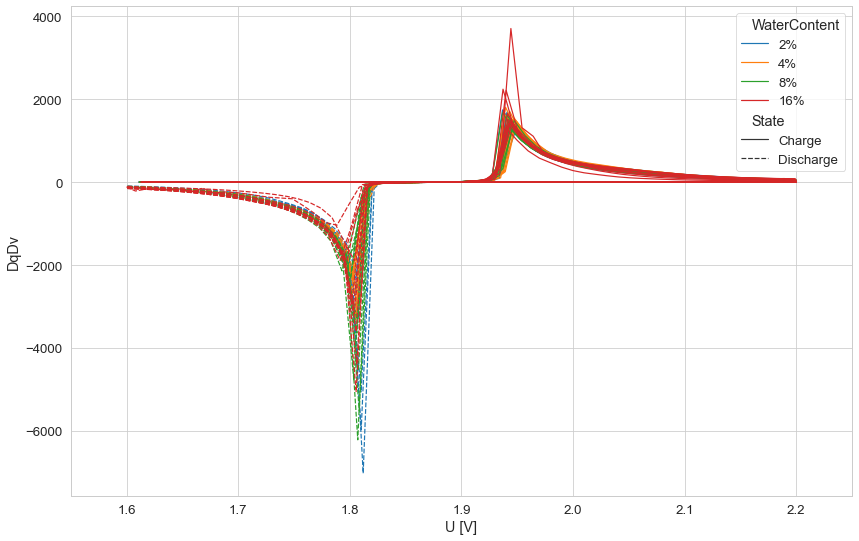

In [236]:
# DqDv plot
fig, axes = plt.subplots(1, 1, figsize=(14, 9))
sns.lineplot(data=dqdv_df.query("Cycle == 10"), x='U [V]', y='DqDv', units='Cell', estimator=None, style='State', hue='WaterContent', ax=axes)
axes.set_xlim(1.55, 2.25)
plt.show()

## Figure 3 Plot
The following cell was used to generate Figure 3 of the manuscript. It combines some of the plots made above.

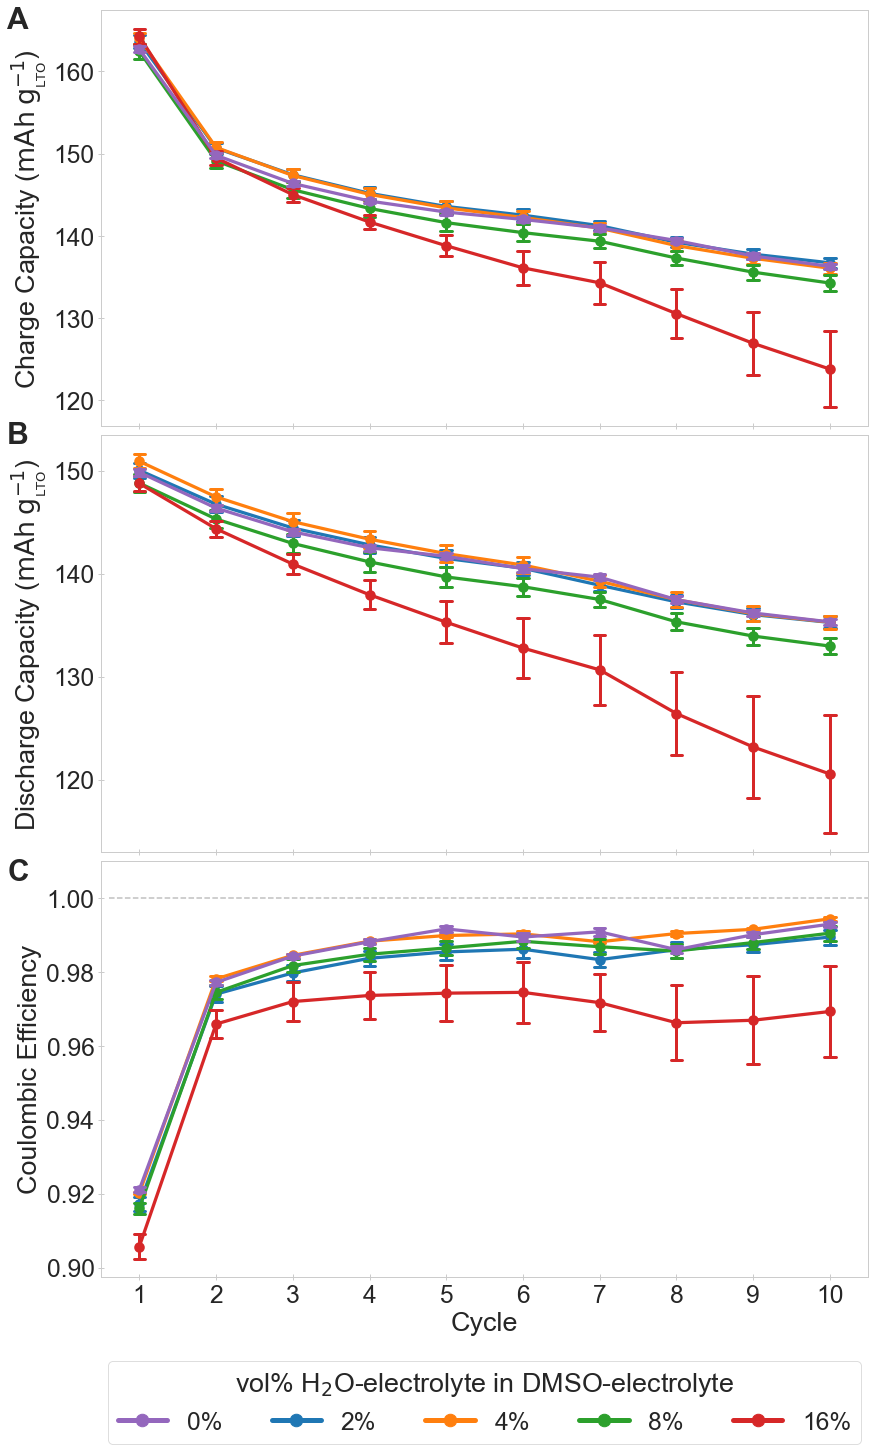

In [27]:
#Althogether

fig = plt.figure(constrained_layout=False, figsize=(12, 20))
spec = fig.add_gridspec(3,1)
spec.update(hspace=0.0)

ax1 = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])
ax3 = fig.add_subplot(spec[2])
ax3.plot([-0.4,10], [1.0, 1.0], '--k', alpha=0.25, linewidth=1.5)

sns.pointplot(x='Cycle', y='Charge Capacity [mAh/g]', data=all_features.query('Cycle < 11'), ax=ax1, hue='WaterContent', capsize=0.15, errwidth=3, errorbar='se', scale=1.5)
sns.pointplot(x='Cycle', y='Discharge Capacity [mAh/g]', data=all_features.query('Cycle < 11'), ax=ax2, hue='WaterContent', capsize=0.15, errwidth=3, errorbar='se', scale=1.5)
sns.pointplot(x='Cycle', y='Coulombic Efficiency', data=all_features.query('Cycle < 11'), ax=ax3, hue='WaterContent', capsize=0.15, errwidth=3, errorbar='se', scale=1.5)


ax1.set_ylabel(r'Charge Capacity ($\mathrm{mAh\:g^{-1}_{_{LTO}}}$)')
ax1.set_xlabel('')
ax1.get_legend().set_visible(False)
ax1.tick_params(axis='both', direction='inout', length=6, top=False, right=False, reset=True, color='0.8')
ax1.set_xticklabels(())
ax1.yaxis.grid(False)
ax1.xaxis.grid(False)

ax2.set_ylabel(r'Discharge Capacity ($\mathrm{mAh\:g^{-1}_{_{LTO}}}$)')
ax2.set_xlabel('')
ax2.get_legend().set_visible(False)
ax2.tick_params(axis='both', direction='inout', length=6, top=False, right=False, reset=True, color='0.8')
ax2.set_xticklabels(())
ax2.yaxis.grid(False)
ax2.xaxis.grid(False)

ax3.tick_params(axis='both', direction='inout', length=6, top=False, right=False, reset=True, color='0.8')
ax3.yaxis.grid(False)
ax3.xaxis.grid(False)
ax3.set_ylim(top=1.01)
#ax3.plot([0,10], [1.0, 1.0], '--k', alpha=0.1)
fig.text(0,0.985, 'A', fontdict={'weight': 'bold', 'size': 30})
fig.text(0,2/3+0.03, 'B', fontdict={'weight': 'bold', 'size': 30})
fig.text(0,1/3+0.06, 'C', fontdict={'weight': 'bold', 'size': 30})

legend_handle0 = mlines.Line2D([], [], color=sns.color_palette('tab10')[4], marker='.', linestyle='solid', markersize=25, linewidth=5, label='0%')
legend_handle1 = mlines.Line2D([], [], color=sns.color_palette('tab10')[0], marker='.', linestyle='solid', markersize=25, linewidth=5, label='2%')
legend_handle2 = mlines.Line2D([], [], color=sns.color_palette('tab10')[1], marker='.', linestyle='solid', markersize=25, linewidth=5, label='4%')
legend_handle3 = mlines.Line2D([], [], color=sns.color_palette('tab10')[2], marker='.', linestyle='solid', markersize=25, linewidth=5, label='8%')
legend_handle4 = mlines.Line2D([], [], color=sns.color_palette('tab10')[3], marker='.', linestyle='solid', markersize=25, linewidth=5, label='16%')
ax3.legend(handles=[legend_handle0, legend_handle1, legend_handle2, legend_handle3, legend_handle4], loc='center', bbox_to_anchor=(0.5,-0.3), ncols=5, title='vol% H$_2$O-electrolyte in DMSO-electrolyte')
fig.savefig('figure3.svg', format='svg')
plt.show()

## Figure 4 Plot

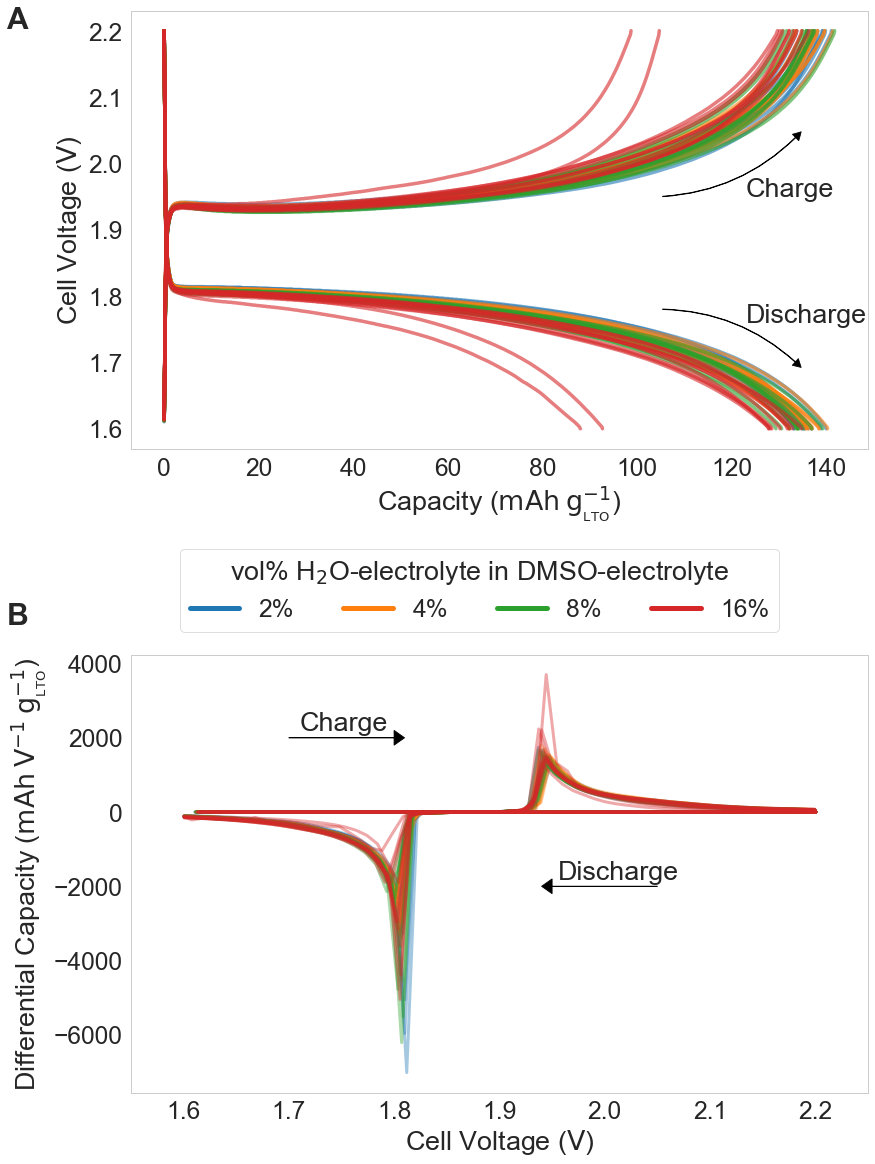

In [18]:
import matplotlib.patches as patches
fig = plt.figure(constrained_layout=True, figsize=(12, 16))
spec = fig.add_gridspec(2,1)
spec.update(hspace=0.04)

ax1 = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])

sns.lineplot(y='U [V]', x='C [Ah/kg]', data=pd.concat([charge_curve, discharge_curve]).reset_index(), hue='WaterContent', style='State', dashes=False, units='Cell', estimator=None, ax=ax1, alpha=0.6, lw=3.5)
sns.lineplot(data=dqdv_df.query("Cycle == 10"), x='U [V]', y='DqDv', units='Cell', estimator=None, style='State', dashes=False, hue='WaterContent', ax=ax2, alpha=0.4, lw=3)

ax1.set_ylabel(r'Cell Voltage ($\mathrm{V}$)')
ax1.set_xlabel(r'Capacity ($\mathrm{mAh\:g^{-1}_{_{LTO}}}$)')
ax1.xaxis.grid(False)
ax1.yaxis.grid(False)

ax2.set_xlim(1.55, 2.25)
ax2.set_xlabel(r'Cell Voltage ($\mathrm{V}$)')
ax2.set_ylabel(r'Differential Capacity ($\mathrm{mAh\: V^{-1}\:g^{-1}_{_{LTO}}}$)')
ax2.xaxis.grid(False)
ax2.yaxis.grid(False)
ax2.get_legend().set_visible(False)

style = "Simple, tail_width=0.5, head_width=9, head_length=8"
kw = dict(arrowstyle=style, color="k")
a = patches.FancyArrowPatch((105, 1.95), (135, 2.05), connectionstyle="arc3,rad=.2", **kw)
ax1.add_patch(a)
ax1.annotate('Charge', xy=(123, 1.95))
a2 = patches.FancyArrowPatch((105, 1.78), (135, 1.69), connectionstyle="arc3,rad=-.2", **kw)
ax1.add_patch(a2)
ax1.annotate('Discharge', xy=(123, 1.76))


ax2.arrow(x=1.7, y=2000, dx=0.1, dy=0, head_width=400, head_length=0.01, color="k")
ax2.annotate('Charge', xy=(1.71, 2200))
ax2.arrow(x=2.05, y=-2000, dx=-0.1, dy=0, head_width=400, head_length=0.01, color="k")
ax2.annotate('Discharge', xy=(1.955, -1800))

fig.text(0,0.982, 'A', fontdict={'weight': 'bold', 'size': 30})
fig.text(0,0.465, 'B', fontdict={'weight': 'bold', 'size': 30})

legend_handle1 = mlines.Line2D([], [], color=sns.color_palette('tab10')[0], marker='None', linestyle='solid', markersize=20, linewidth=5, label='2%')
legend_handle2 = mlines.Line2D([], [], color=sns.color_palette('tab10')[1], marker='None', linestyle='solid', markersize=20, linewidth=5, label='4%')
legend_handle3 = mlines.Line2D([], [], color=sns.color_palette('tab10')[2], marker='None', linestyle='solid', markersize=20, linewidth=5, label='8%')
legend_handle4 = mlines.Line2D([], [], color=sns.color_palette('tab10')[3], marker='None', linestyle='solid', markersize=20, linewidth=5, label='16%')
ax1.legend(handles=[legend_handle1, legend_handle2, legend_handle3, legend_handle4], loc=2, bbox_to_anchor=(0.05,-0.2), ncols=4, title='vol% H$_2$O-electrolyte in DMSO-electrolyte')
fig.savefig('figure4.svg', format='svg')
plt.show()

## Individual Dis/charge Curves for Each Tested Coin Cell
The charge and discharge curves of 16 cells are plotted below to visually inspect each cell's performance.

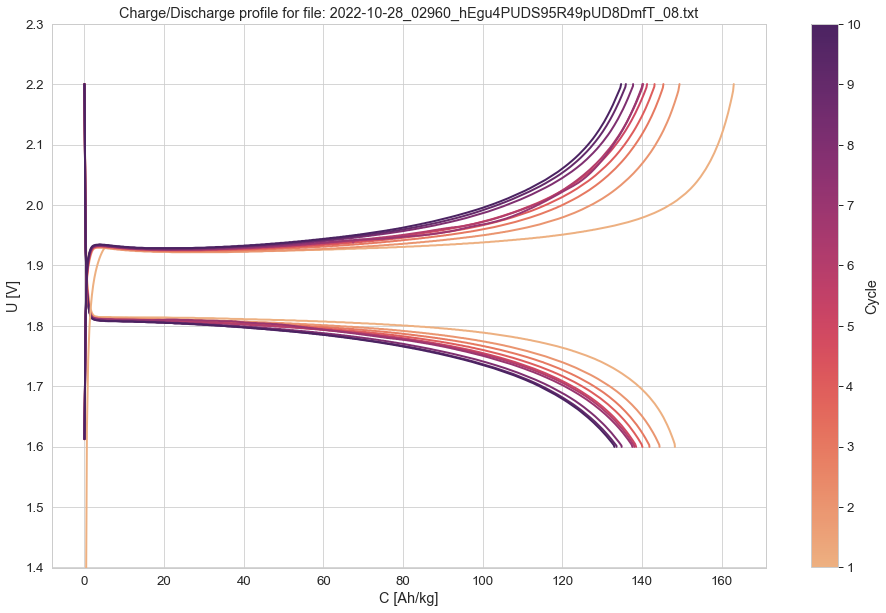

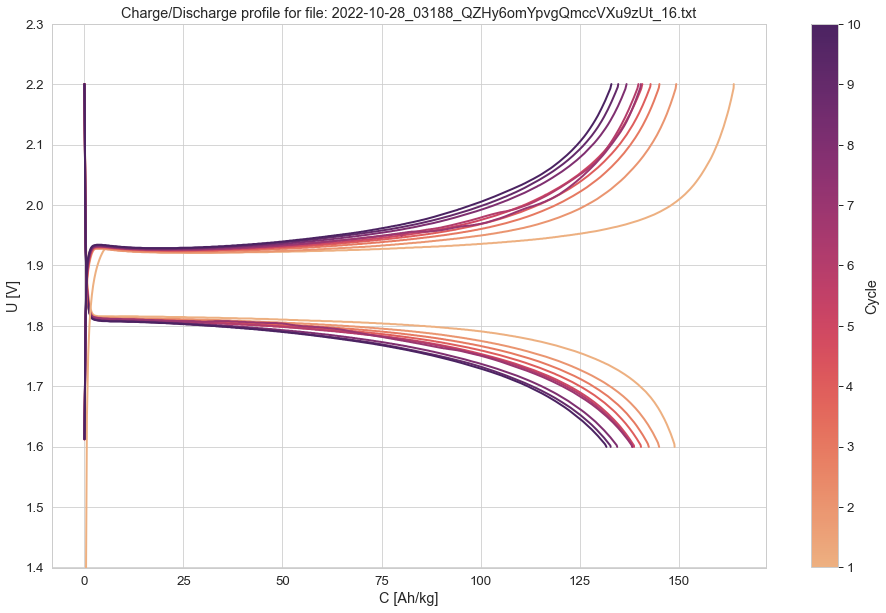

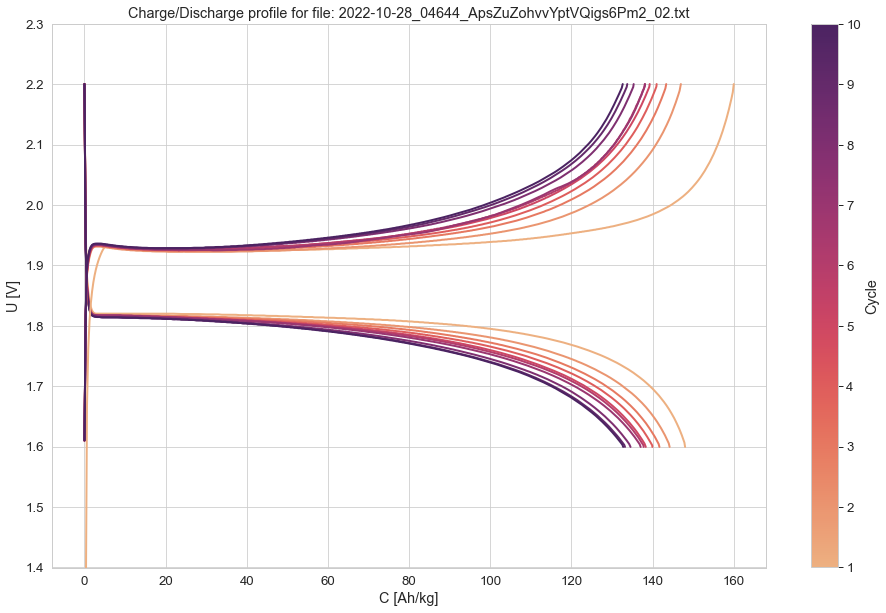

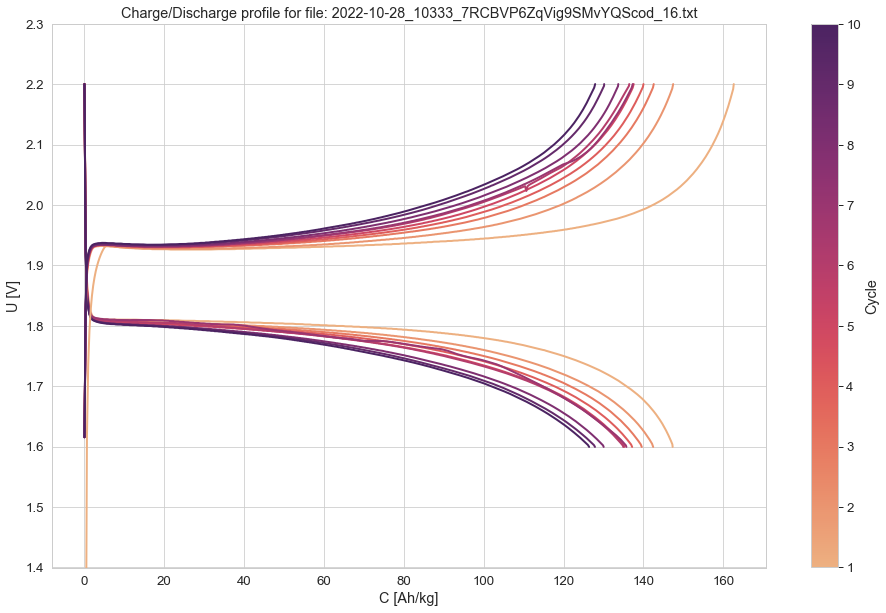

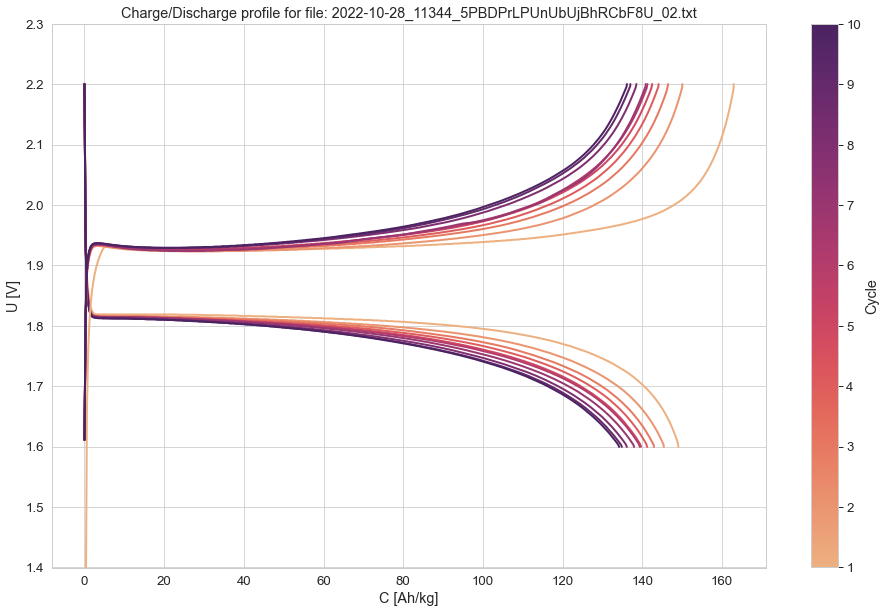

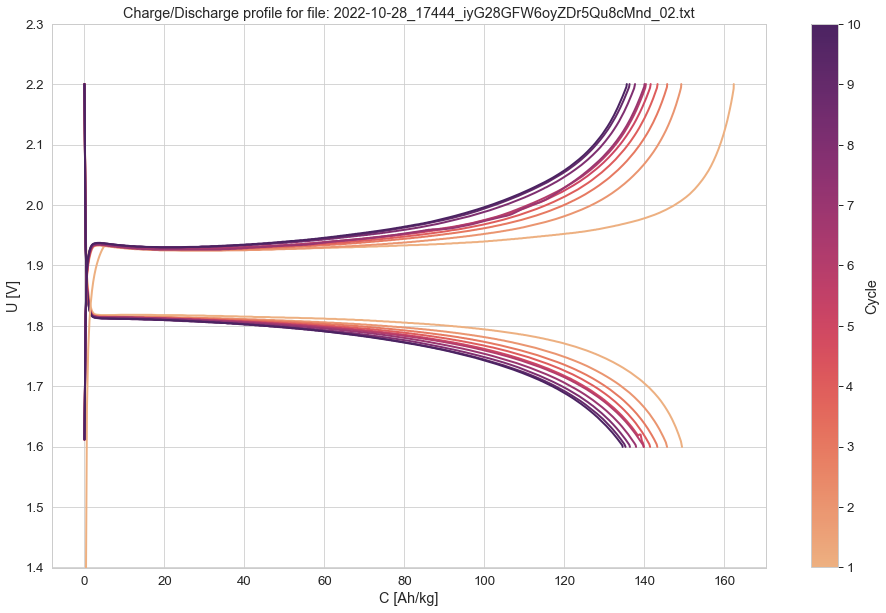

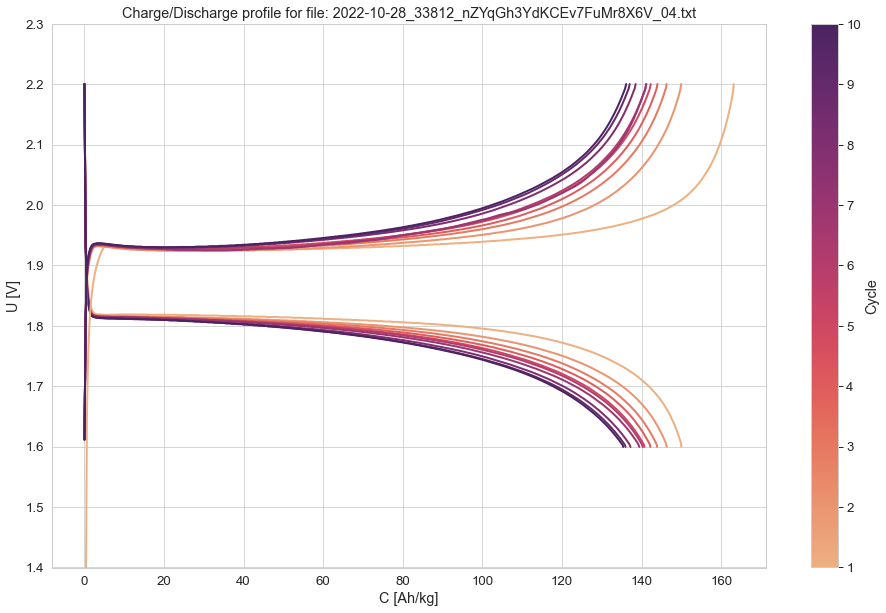

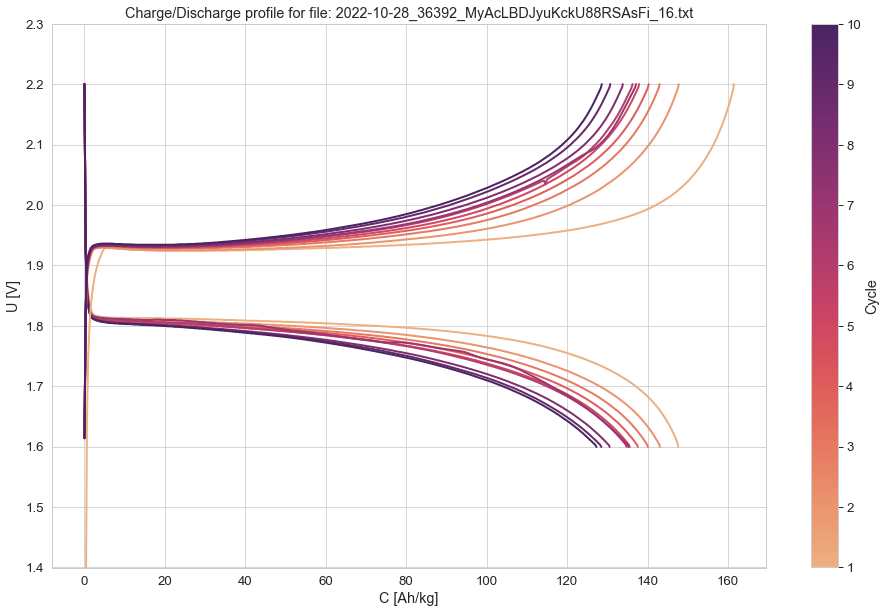

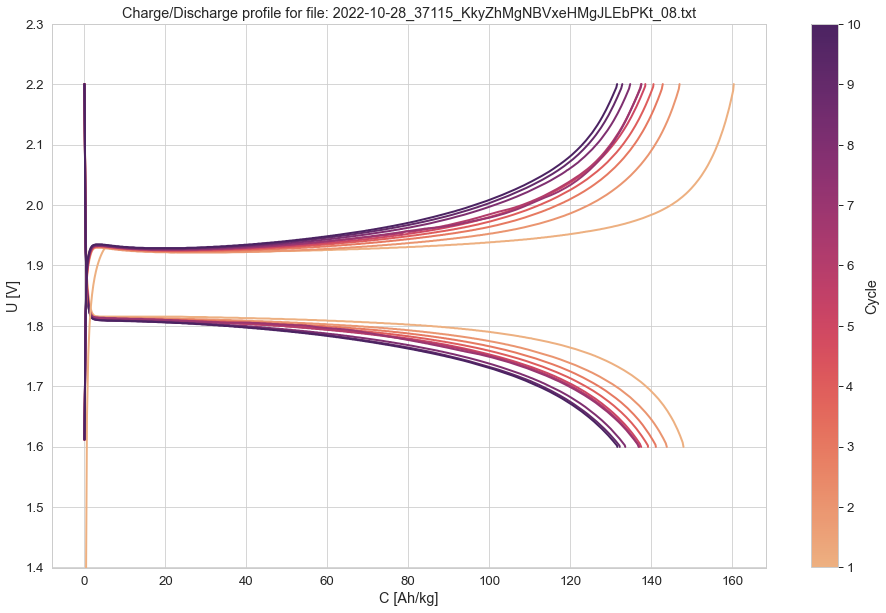

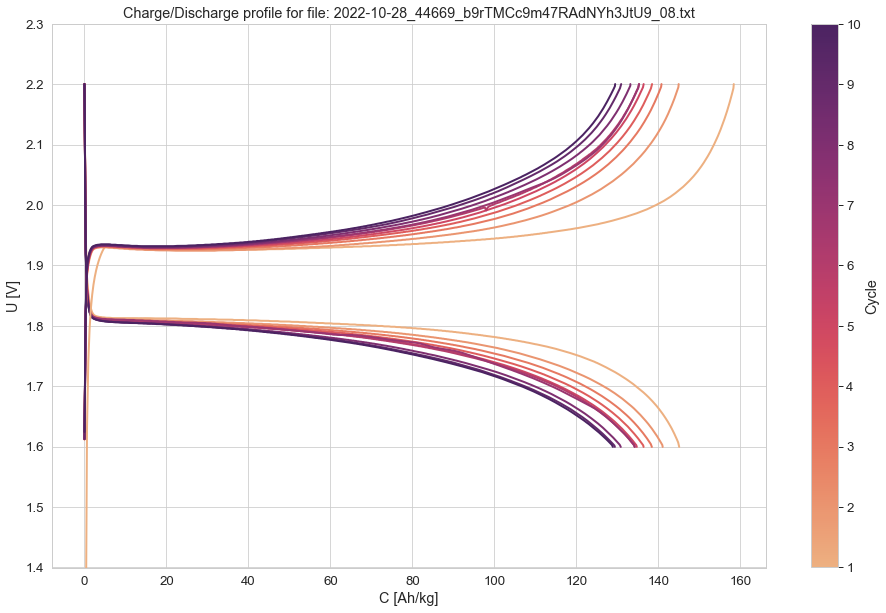

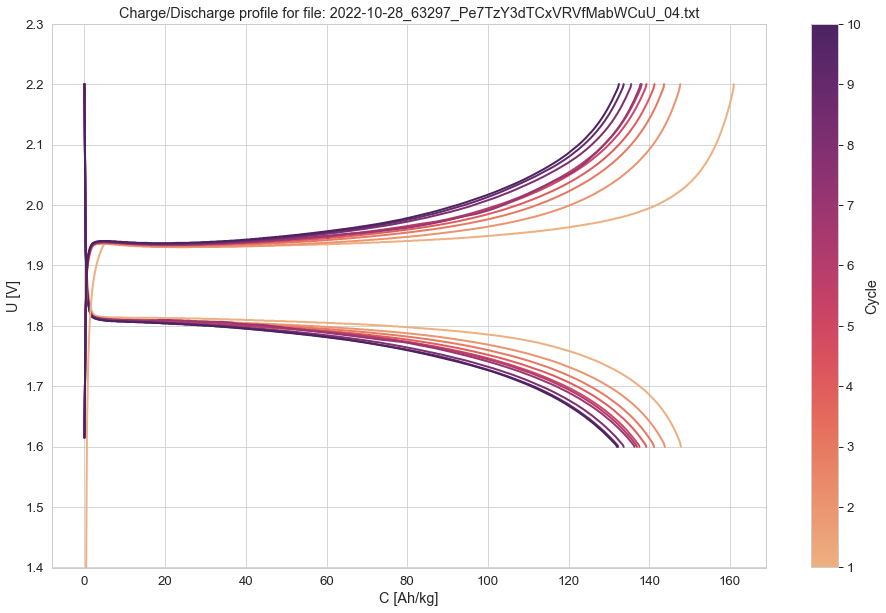

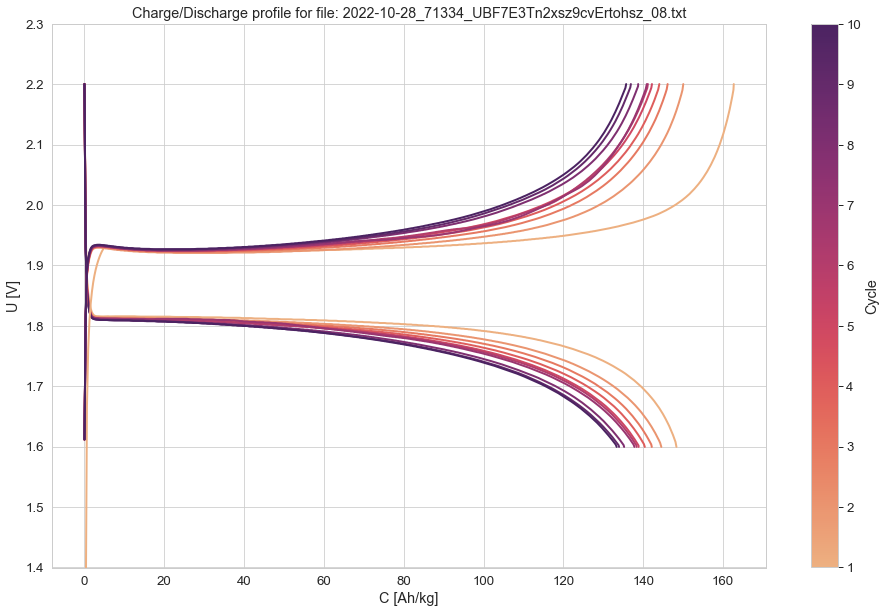

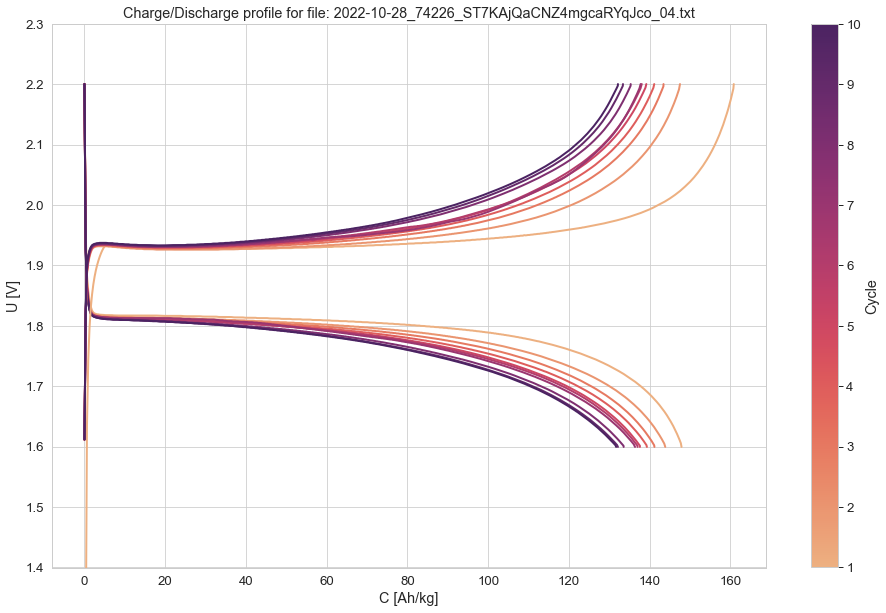

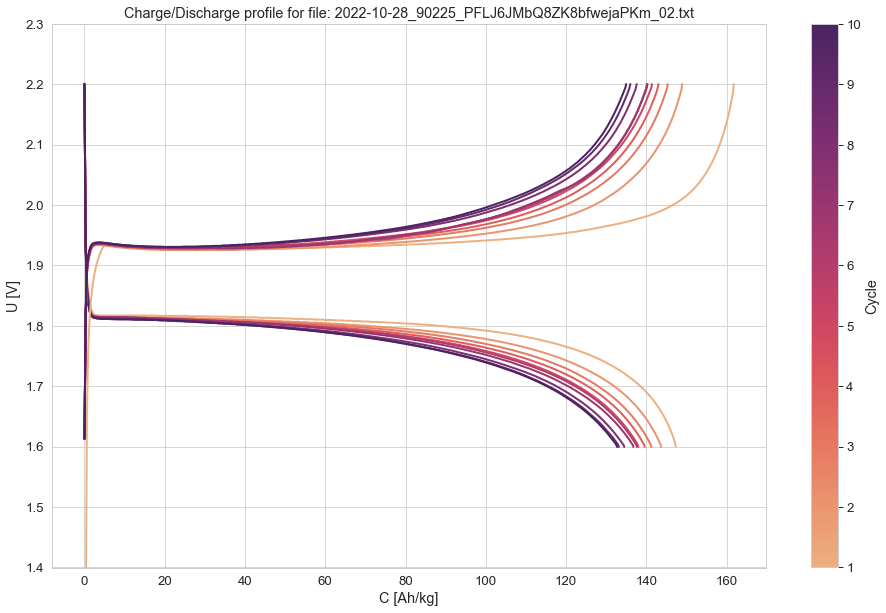

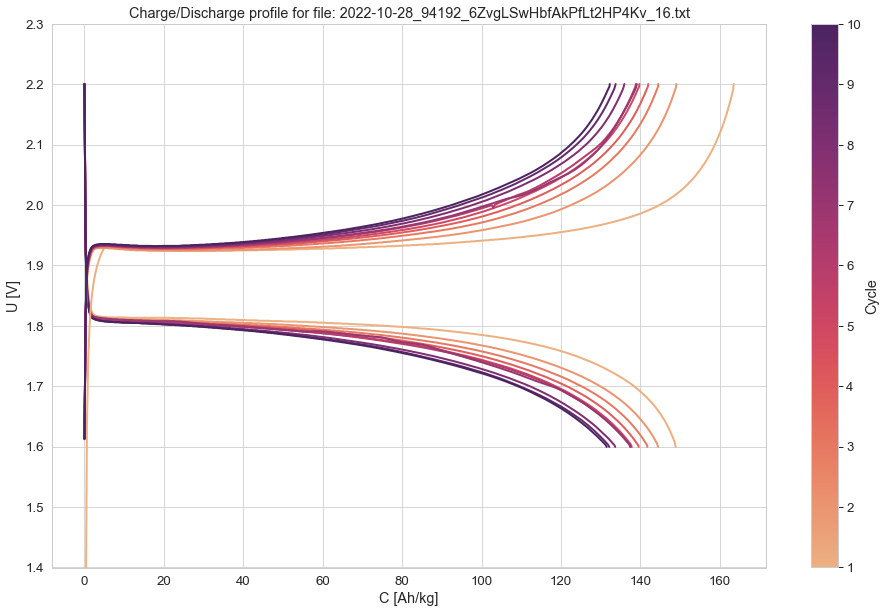

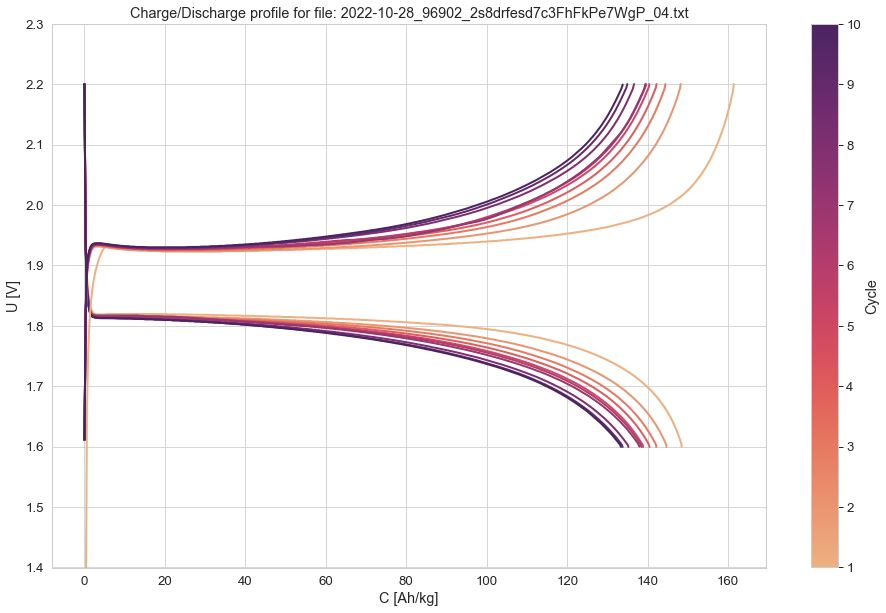

In [11]:
import matplotlib as mpl

for file in all_df.index.levels[0].values:
    fig, axes = plt.subplots(1, 1, figsize=(16, 10))
    charge_curve = all_df.query("Cell == @file & State == 'Charge'")
    discharge_curve = all_df.query("Cell == @file & State == 'Discharge'")
    if SoC:
        for cycle, val in charge_curve.groupby('Z1 []')['C [Ah/kg]'].max().to_dict().items():
            charge_curve.loc[charge_curve['Z1 []'] == cycle, 'C [Ah/kg]'] *= 100/val
            discharge_curve.loc[discharge_curve['Z1 []'] == cycle, 'C [Ah/kg]'] *= 100/val
    if Startat0:
        discharge_curve = discharge_curve.assign(**{'C [Ah/kg]': discharge_curve['C [Ah/kg]']*-1})
    else:
        for cycle, val in charge_curve.groupby('Z1 []')['C [Ah/kg]'].max().to_dict().items():
            discharge_curve.loc[discharge_curve['Z1 []'] == cycle, 'C [Ah/kg]'] += val
    sns.lineplot(x='C [Ah/kg]', y='U [V]', hue='Z1 []', data=discharge_curve, ax=axes, legend=False, lw=2, palette='flare')
    sns.lineplot(x='C [Ah/kg]', y='U [V]', hue='Z1 []', data=charge_curve, ax=axes, lw=2, palette='flare')

    norm = plt.Normalize(charge_curve['Z1 []'].min(), charge_curve['Z1 []'].max())
    sm = plt.cm.ScalarMappable(cmap="flare", norm=norm)
    sm.set_array([])

# Remove the legend and add a colorbar
    axes.set_title('Charge/Discharge profile for file: {}'.format(file))
#axes.set_title('Charge/Discharge profile: Assembled in air')
    axes.get_legend().remove()
    plt.colorbar(sm, label='Cycle', ax=axes)
    axes.set_ylim(1.4,2.3)
    fig.savefig(file.split('.')[0])
    plt.show()